# install library

In [1]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True
if not ON_KAGGLE:
    import shutil
    from requests import get

    from google.colab import drive, files
    # mount Google Drive
    drive.mount("/content/drive")
else:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
if not ON_KAGGLE: 
    !pip uninstall -y kaggle
    !pip install kaggle
    !mkdir /root/.kaggle
    !cp /content/drive/MyDrive/kaggla-za/kaggle.json /root/.kaggle
    !kaggle datasets download -d  kozodoi/timm-pytorch-image-models
    !mkdir -p ../input/timm-pytorch-image-models
    !unzip -n -qq timm-pytorch-image-models.zip -d ../input/timm-pytorch-image-models

    #一回のみ
    # !kaggle datasets download -d kalfirst/animal-imbalance-classification-round2
    # !mkdir -p ../content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/data/animal-imbalance-classification-round2
    # !unzip -n -qq animal-imbalance-classification-round2.zip -d ../content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/data/animal-imbalance-classification-round2

    !kaggle datasets download -d kalfirst/animal-imbalance-classification-round2
    !mkdir -p ../input/animal-imbalance-classification-round2
    !unzip -n -qq animal-imbalance-classification-round2.zip -d ../input/animal-imbalance-classification-round2


Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
  Using cached kaggle-1.5.12-py3-none-any.whl
mkdir: cannot create directory ‘/root/.kaggle’: File exists
timm-pytorch-image-models.zip: Skipping, found more recently modified local copy (use --force to force download)
animal-imbalance-classification-round2.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import sys
sys.path.append("../input/timm-pytorch-image-models/pytorch-image-models-master")

if not ON_KAGGLE:
    !pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

import gc
import math
import os
import pickle
import random
import re
import time
import warnings
from contextlib import contextmanager

from pathlib import Path
from PIL import Image

#import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F


#from albumentations.pytorch import ToTensorV2
from scipy.special import softmax
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.optim import SGD, Adam, AdamW, RAdam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

import timm
warnings.filterwarnings('ignore')

# Config


In [4]:
class Config:
    Version = "exp21" # model save時のversion
    #MODEL_NAME = "resnet34" # モデル名
    #MODEL_NAME = "efficientnet_b0" # モデル名
    #MODEL_NAME = "efficientnet_b1" # モデル名
    #MODEL_NAME = "efficientnet_b2" # モデル名
    #MODEL_NAME = "efficientnet_b3" # モデル名
    #MODEL_NAME = "efficientnet_b4" # モデル名
    #MODEL_NAME = "efficientnet_b5" # モデル名
    #MODEL_NAME = "efficientnet_b6" # モデル名
    #MODEL_NAME = "efficientnet_b7" # モデル名
    MODEL_NAME = "tf_efficientnet_b0_ns" # モデル名
    #MODEL_NAME = "tf_efficientnet_b1_ns" # モデル名
    #MODEL_NAME = "tf_efficientnet_b2_ns" # モデル名
    #MODEL_NAME = "resnet50" # モデル名
    #MODEL_NAME = "swin_large_patch4_window7_224"
    #MODEL_NAME = "swin_base_patch4_window7_224"
    #MODEL_NAME = "swin_small_patch4_window7_224"
    #MODEL_NAME = "swin_large_patch4_window12_384"
    #MODEL_NAME = "swin_base_patch4_window12_384"


    if ON_KAGGLE:
        # if MODEL_NAME == 'resnet34':
        #     model_name = '../input/pt-longformer-base' # https://www.kaggle.com/kishalmandal/pt-longformer-base
        # elif MODEL_NAME == 'roberta-base':
        #     model_name = '../input/roberta-base' #https://www.kaggle.com/abhishek/roberta-base
        # elif modeMODEL_NAMEl_savename == 'roberta-large':
        #     model_name = '../input/robertalarge' # https://www.kaggle.com/marshal02/robertalarge
        # elif MODEL_NAME == 'longformer-large':
        #     model_name = '../input/longformerlarge4096' # https://www.kaggle.com/hengzheng/longformerlarge4096 
        #base_dir = '/content/drive/MyDrive/petfinder'
        #data_dir = '../input/digit-recognizer/' # = DATA_PATH
        data_dir = '../input/animal-imbalance-classification-round2' # = DATA_PATH
        pre_data_dir = './preprocessed/'
        model_dir = '.'
        output_dir = '.'   
    else:
        # customize for my own Google Colab Environment
        # if model_savename == 'longformer':
        #     model_name = 'allenai/longformer-base-4096'
        # elif model_savename == 'roberta-base':
        #     model_name = 'roberta-base'
        base_dir = '/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance'
        data_dir = '../input/animal-imbalance-classification-round2' #os.path.join(base_dir, '../input/animal-imbalance-classification-round2')
        #pre_data_dir = os.path.join(base_dir, 'data/preprocessed')
        model_dir = os.path.join(base_dir, f'model/{Version}')
        output_dir = os.path.join(base_dir, f'output/{Version}')    

    is_debug = False
    if MODEL_NAME == 'resnet34':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'roberta-base':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'resnet50':
        size = 64 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_large_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_base_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_small_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_large_patch4_window12_384':
        size = 384 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_base_patch4_window12_384':
        size = 384 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b0':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b1':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b2':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b3':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b4':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b5':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b6':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5    
    elif MODEL_NAME == 'efficientnet_b7':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'tf_efficientnet_b0_ns':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'tf_efficientnet_b1_ns':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'tf_efficientnet_b2_ns':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    seed = 42 # seed値
    fold = 0
    num_workers = 4  #並列実行する数 was 0
    batch_size =  64 #バッチサイズ was 64 >100
    epochs = 50 #エポック数 10?
    #size = 224 # リサイズした後の画像のサイズ
    #model_lr = 1e-5 # 学習率
    T_max = 10 # 最大イテレーション数 was 10
    min_lr = 1e-3 # 学習率の最小値 was 1e-5
    weight_decay = 1e-6 # 学習減衰値
    max_grad_norm = 1000 # 勾配の最大ノルム
    print_freq = 1000 # 学習結果を表示する頻度
    probability = 0.6
    class_num = 10 
    norms = (0.5, 0.5)
    device = "cuda" if torch.cuda.is_available() else "cpu" # CPU of GPU


In [5]:
if not ON_KAGGLE:
    if not os.path.exists(Config.model_dir):
        !mkdir $Config.model_dir
    if not os.path.exists(Config.output_dir):
        !mkdir $Config.output_dir

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

# Utils

In [7]:
def init_logger(log_file='train.log'):
    """Output Log."""
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def seed_torch(seed=Config.seed): # was seed=0
    """Fixed seed value."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # added trueにすると再現性がなくなる


LOGGER = init_logger()
seed_torch(seed=Config.seed)

In [8]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Dataset

In [9]:
class TrainDataset(Dataset):
    """Dataset used for training."""
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #修正部分
        path = self.image_paths[idx]
        image = np.array(Image.open(path))
        # image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28) # csv to image
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) # GRAY to RGB

        if self.transform:
            augmented = self.transform(image=image) # augmentation
            image = augmented['image']

        label = self.labels[idx] # 正解ラベル
        return image, label

In [10]:
class TestDataset(Dataset):
    """Dataset used for inference."""
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #修正部分
        path = self.image_paths[idx]
        image = np.array(Image.open(path))
        # image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28)
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image

# Data Augmentation

In [11]:
def get_transforms(*, data, size, norms):

    if data == 'train':
        return A.Compose([
            A.Resize(Config.size, Config.size), # リサイズ
            A.Rotate(limit=10, border_mode=cv2.BORDER_REPLICATE, p=0.5),
            A.Cutout(num_holes=8, max_h_size=2, max_w_size=2, fill_value=0, p=0.5),
            A.Cutout(num_holes=8, max_h_size=1, max_w_size=1, fill_value=1, p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0), # 正規化
            ToTensorV2(), # Tensor型に変換
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(Config.size, Config.size),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0),
            ToTensorV2(),
        ])

# Model

In [12]:
# use timm model no pretrained
class BaseModel(nn.Module):
    def __init__(
        self, model_name=Config.MODEL_NAME, n_class=10, pretrained=False
    ):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained) # model load(pretrained=False: 事前学習なし)
        n_features = self.model.num_features#fc.in_features
        self.model.classifier = nn.Linear(n_features, n_class) # 出力層の次元をクラス数に変更

    def forward(self, x):
        output = self.model(x)
        return output

# train & valid function

In [13]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.train() # 学習モード
    start = end = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device) # 画像をcpuからgpuヘ
        labels = labels.to(Config.device) # 正解ラベルをcpuからgpuヘ
        batch_size = labels.size(0) 
        y_preds = model(images) # 予測ラベル
        loss = criterion(y_preds, labels) # lossの計算

        losses.update(loss.item(), batch_size) 
        loss.backward() # パラメータの勾配を計算
        
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), Config.max_grad_norm)
        optimizer.step() # モデル更新
        optimizer.zero_grad() # 勾配の初期化
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))

        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()
    
    return losses.avg

In [14]:
def valid_fn(valid_loader, model, criterion):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device)
        labels = labels.to(Config.device)
        batch_size = labels.size(0)
        with torch.no_grad():
        #with torch.inference_mode(): Pytorch: ^1.9
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            losses.update(loss.item(), batch_size)
            
            preds.append(y_preds.softmax(1).to("cpu").numpy().argmax(1))
            del loss
            batch_time.update(time.time() - end)
            end = time.time()
            if step % Config.print_freq == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                    'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(
                    step, len(valid_loader), batch_time=batch_time,
                    data_time=data_time, loss=losses,
                    remain=timeSince(start, float(step+1)/len(valid_loader)),
                    ))
        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()

    preds = np.concatenate(preds)

    return losses.avg, preds

# Dataの確認

In [15]:
#data_dir = "../input/digit-recognizer" # ディレクトリパス = data_dir
if ON_KAGGLE:
    train = pd.read_csv(Config.data_dir + "/train.csv") # csvの読み込み
    train['image_id'] = Config.data_dir + '/train_images/' + train['image_id']
else:
    train = pd.read_csv(f'{Config.data_dir}/train.csv')
    train['image_id'] = Config.data_dir + '/train_images/' + train['image_id']

train.head()

image_id  label
0  ../input/animal-imbalance-classification-round...      0
1  ../input/animal-imbalance-classification-round...      0
2  ../input/animal-imbalance-classification-round...      0
3  ../input/animal-imbalance-classification-round...      0
4  ../input/animal-imbalance-classification-round...      0

In [16]:
#train['image_id'][0]

In [17]:
import plotly.express as px

target = train.label.value_counts()
#class_num = len(target)

fig = px.pie(target,
             values='label',
             names=target.index,
             hole=.4, 
             width=500, height=500)
fig.update_traces(textinfo='value+label', pull=0.01)
fig.show()

In [18]:
fig = px.bar(target.sort_index().index, target.sort_index(), width=1000, height=400)
fig.show()

# 前処理

### ホールドアウト

In [19]:
f0, f1 = train_test_split(train, test_size=0.2) # 学習用と評価用に分ける
train["folds"] = -1
train.loc[f0.index, "folds"] = 1
train.loc[f1.index, "folds"] = 0
train

image_id  label  folds
0      ../input/animal-imbalance-classification-round...      0      1
1      ../input/animal-imbalance-classification-round...      0      1
2      ../input/animal-imbalance-classification-round...      0      1
3      ../input/animal-imbalance-classification-round...      0      1
4      ../input/animal-imbalance-classification-round...      0      0
...                                                  ...    ...    ...
36495  ../input/animal-imbalance-classification-round...      9      1
36496  ../input/animal-imbalance-classification-round...      9      1
36497  ../input/animal-imbalance-classification-round...      9      1
36498  ../input/animal-imbalance-classification-round...      9      1
36499  ../input/animal-imbalance-classification-round...      9      0

[36500 rows x 3 columns]

#### 平均と標準偏差を計算

In [20]:
#修正部分
# images = train.loc[:, "pixel0": "pixel783"].values.astype(np.uint8).reshape(-1, 28, 28)
# norms = (np.mean(images[train.folds!=0] / 255), np.std(images[train.folds!=0] / 255)) # 平均と標準偏差を計算
# print("平均と標準偏差: ", norms)

#### 画像サイズの確認と数例を表示

In [21]:
# norms = (0.5, 0.5)
# train_dataset = TrainDataset(train,transform=get_transforms(data='train', size=Config.size, norms=Config.norms)) # 学習用のdatasetを作成
# train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
# image_iter = iter(train_loader)
# images, labels = image_iter.next()

In [22]:
# print("height: ", images.shape[1])
# print("weight: ", images.shape[2])

# for n in range(3):
#     fig, axes = plt.subplots(1, 10, figsize=(20, 30))
#     [axes[i].imshow(images[idx]) for i, idx in enumerate(range(n*10, (n+1)*10))]

#     plt.show()

# 学習の際必要になる知識

## 評価指標(Accuracy), Confusion matrix
#### 詳細については、来週説明

## ハイパラメータの用語簡易説明など

> #### * 学習率 : 学習一回当たりの更新量のようなものです。 今回のデフォルトは1e-5です。
> #### * スケジューラー : epoch数に応じて、学習率を変化させるものです。 今回のデフォルトはCosineAnnealingLRです。
> #### * 損失関数: 正解ラベルと予測ラベルの誤差の大きさを計算する関数。 
> #### * 最適化関数: 効率よく損失を減らすための関数。 
> #### * timm : 画像のコンペでpytorchを使う場合にほぼ確実に使用するライブラリですので、見ておきましょう。[github](https://github.com/rwightman/pytorch-image-models)

# 軽めのモデル作成

### モデルの読み込み

In [23]:
model = BaseModel(Config.MODEL_NAME, Config.class_num)
model

BaseModel(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_runnin

### 最適化関数

In [24]:
# Adam は勾配を移動平均と学習率の調整からなります (MomentumとRMSProp)
#optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
#optimizer = AdamW(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
optimizer = RAdam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay)


### スケジューラ

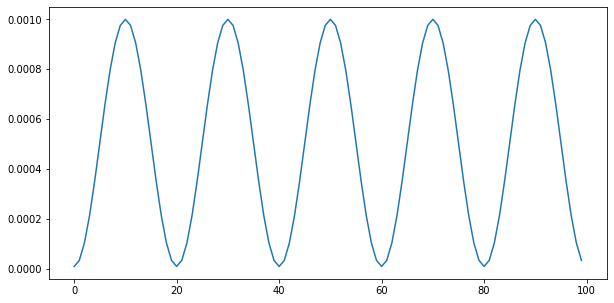

In [25]:
scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=0.001)

log_s = []
for epoch in range(0, 100):
    log_s.append(scheduler.get_last_lr()[0])
    scheduler.step()

plt.figure(figsize=(10, 5))
plt.plot(np.arange(100), log_s)
plt.show()

# 学習

In [26]:
def train_loop(train, fold, class_num=None, norms=(0.5, 0.5)):
    
    train_index = train[train['folds'] != fold].index # 学習用のindex
    valid_index = train[train['folds'] == fold].index # 評価用のindex

    train_dataset = TrainDataset(train.loc[train_index].reset_index(drop=True), 
                                 transform=get_transforms(data='train', size=Config.size, norms=norms)) # 学習用のdatasetを作成
    valid_dataset = TrainDataset(train.loc[valid_index].reset_index(drop=True), 
                                 transform=get_transforms(data='valid', size=Config.size, norms=norms)) # 評価用のdatasetを作成

    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
    valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=False) # 評価用のdatasetsのbatchを作成
    
    
    model = BaseModel(Config.MODEL_NAME, class_num).to(Config.device)

    #optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
    #optimizer = AdamW(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
    optimizer = RAdam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay)

    scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=Config.min_lr, last_epoch=-1)

    criterion = nn.CrossEntropyLoss() # loss function

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(Config.epochs):
        start_time = time.time()
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler) # 学習
        avg_val_loss, predict = valid_fn(valid_loader, model, criterion) # 評価用の推論
        valid_labels = train.loc[valid_index, "label"].values # 予測ラベル
        
        scheduler.step() 
        score = accuracy_score(valid_labels, predict) # 適合率を計算
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            model_filename = f'{Config.model_dir}/{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth'
            torch.save(model.state_dict(), model_filename) # モデルの保存
            #torch.save(model.state_dict(), "./" + f'{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth') # モデルの保存
            print(f'{model_filename} saved')

            valid_folds_predict = predict
            
        del avg_loss, avg_val_loss, valid_labels, predict, score
        gc.collect()
        torch.cuda.empty_cache()

    return valid_folds_predict

In [27]:
preds = train_loop(train, fold=Config.fold, class_num=Config.class_num, norms=Config.norms)

Epoch: [1][0/456] Data 1.499 (1.499) Elapsed 0m 2s (remain 21m 13s) Loss: 2.3263(2.3263) 
Epoch: [1][455/456] Data 0.000 (0.004) Elapsed 3m 54s (remain 0m 0s) Loss: 2.2583(2.2865) 
EVAL: [0/115] Data 0.672 (0.672) Elapsed 0m 0s (remain 1m 40s) Loss: 2.2343(2.2343) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 2.4899(2.3594) 


Epoch 1 - avg_train_loss: 2.2865  avg_val_loss: 2.3594  time: 250s
Epoch 1 - Accuracy: 0.1426027397260274
Epoch 1 - Save Best Score: 0.1426 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [2][0/456] Data 0.870 (0.870) Elapsed 0m 1s (remain 12m 12s) Loss: 2.2655(2.2655) 
Epoch: [2][455/456] Data 0.000 (0.002) Elapsed 3m 55s (remain 0m 0s) Loss: 1.9991(2.1411) 
EVAL: [0/115] Data 0.597 (0.597) Elapsed 0m 0s (remain 1m 29s) Loss: 1.4708(1.4708) 
EVAL: [114/115] Data 0.000 (0.009) Elapsed 0m 15s (remain 0m 0s) Loss: 4.0300(2.1214) 


Epoch 2 - avg_train_loss: 2.1411  avg_val_loss: 2.1214  time: 251s
Epoch 2 - Accuracy: 0.25794520547945204
Epoch 2 - Save Best Score: 0.2579 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [3][0/456] Data 0.773 (0.773) Elapsed 0m 1s (remain 12m 9s) Loss: 1.9894(1.9894) 
Epoch: [3][455/456] Data 0.000 (0.002) Elapsed 3m 55s (remain 0m 0s) Loss: 1.2737(1.7101) 
EVAL: [0/115] Data 0.582 (0.582) Elapsed 0m 0s (remain 1m 25s) Loss: 2.0111(2.0111) 
EVAL: [114/115] Data 0.000 (0.009) Elapsed 0m 15s (remain 0m 0s) Loss: 3.3320(1.6532) 


Epoch 3 - avg_train_loss: 1.7101  avg_val_loss: 1.6532  time: 252s
Epoch 3 - Accuracy: 0.4008219178082192
Epoch 3 - Save Best Score: 0.4008 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [4][0/456] Data 0.916 (0.916) Elapsed 0m 1s (remain 12m 33s) Loss: 1.5492(1.5492) 
Epoch: [4][455/456] Data 0.000 (0.002) Elapsed 3m 57s (remain 0m 0s) Loss: 1.4287(1.4812) 
EVAL: [0/115] Data 0.629 (0.629) Elapsed 0m 0s (remain 1m 36s) Loss: 1.1426(1.1426) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 3.1515(1.3572) 


Epoch 4 - avg_train_loss: 1.4812  avg_val_loss: 1.3572  time: 254s
Epoch 4 - Accuracy: 0.5083561643835617
Epoch 4 - Save Best Score: 0.5084 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [5][0/456] Data 0.843 (0.843) Elapsed 0m 1s (remain 12m 1s) Loss: 1.5347(1.5347) 
Epoch: [5][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 1.1241(1.2968) 
EVAL: [0/115] Data 0.691 (0.691) Elapsed 0m 0s (remain 1m 37s) Loss: 0.7999(0.7999) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 15s (remain 0m 0s) Loss: 3.4742(1.1571) 


Epoch 5 - avg_train_loss: 1.2968  avg_val_loss: 1.1571  time: 256s
Epoch 5 - Accuracy: 0.5828767123287671
Epoch 5 - Save Best Score: 0.5829 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [6][0/456] Data 0.921 (0.921) Elapsed 0m 1s (remain 12m 30s) Loss: 1.2253(1.2253) 
Epoch: [6][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.9165(1.1316) 
EVAL: [0/115] Data 0.734 (0.734) Elapsed 0m 0s (remain 1m 45s) Loss: 0.9464(0.9464) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 3.0220(1.0778) 


Epoch 6 - avg_train_loss: 1.1316  avg_val_loss: 1.0778  time: 256s
Epoch 6 - Accuracy: 0.6104109589041096
Epoch 6 - Save Best Score: 0.6104 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [7][0/456] Data 0.653 (0.653) Elapsed 0m 1s (remain 12m 3s) Loss: 1.1233(1.1233) 
Epoch: [7][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.8638(1.0058) 
EVAL: [0/115] Data 0.637 (0.637) Elapsed 0m 0s (remain 1m 34s) Loss: 0.7643(0.7643) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 15s (remain 0m 0s) Loss: 2.2163(0.9247) 


Epoch 7 - avg_train_loss: 1.0058  avg_val_loss: 0.9247  time: 256s
Epoch 7 - Accuracy: 0.6773972602739726
Epoch 7 - Save Best Score: 0.6774 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [8][0/456] Data 0.718 (0.718) Elapsed 0m 1s (remain 11m 59s) Loss: 0.9724(0.9724) 
Epoch: [8][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.8646(0.8958) 
EVAL: [0/115] Data 0.624 (0.624) Elapsed 0m 0s (remain 1m 33s) Loss: 0.6336(0.6336) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 2.3024(0.8799) 


Epoch 8 - avg_train_loss: 0.8958  avg_val_loss: 0.8799  time: 256s
Epoch 8 - Accuracy: 0.6901369863013699
Epoch 8 - Save Best Score: 0.6901 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [9][0/456] Data 0.904 (0.904) Elapsed 0m 1s (remain 12m 44s) Loss: 0.9238(0.9238) 
Epoch: [9][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.6952(0.8088) 
EVAL: [0/115] Data 0.712 (0.712) Elapsed 0m 0s (remain 1m 45s) Loss: 0.5894(0.5894) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 15s (remain 0m 0s) Loss: 0.5586(0.7951) 


Epoch 9 - avg_train_loss: 0.8088  avg_val_loss: 0.7951  time: 256s
Epoch 9 - Accuracy: 0.7297260273972602
Epoch 9 - Save Best Score: 0.7297 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [10][0/456] Data 0.896 (0.896) Elapsed 0m 1s (remain 12m 55s) Loss: 0.8055(0.8055) 
Epoch: [10][455/456] Data 0.000 (0.002) Elapsed 4m 0s (remain 0m 0s) Loss: 0.6262(0.7235) 
EVAL: [0/115] Data 0.490 (0.490) Elapsed 0m 0s (remain 1m 12s) Loss: 0.5893(0.5893) 
EVAL: [114/115] Data 0.000 (0.009) Elapsed 0m 15s (remain 0m 0s) Loss: 1.8387(0.7726) 


Epoch 10 - avg_train_loss: 0.7235  avg_val_loss: 0.7726  time: 256s
Epoch 10 - Accuracy: 0.7305479452054795
Epoch 10 - Save Best Score: 0.7305 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [11][0/456] Data 0.748 (0.748) Elapsed 0m 1s (remain 11m 48s) Loss: 0.6229(0.6229) 
Epoch: [11][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.4083(0.6586) 
EVAL: [0/115] Data 0.414 (0.414) Elapsed 0m 0s (remain 1m 1s) Loss: 1.0703(1.0703) 
EVAL: [114/115] Data 0.000 (0.009) Elapsed 0m 15s (remain 0m 0s) Loss: 2.5256(0.7072) 


Epoch 11 - avg_train_loss: 0.6586  avg_val_loss: 0.7072  time: 256s
Epoch 11 - Accuracy: 0.7632876712328767
Epoch 11 - Save Best Score: 0.7633 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [12][0/456] Data 0.765 (0.765) Elapsed 0m 1s (remain 12m 0s) Loss: 0.6823(0.6823) 
Epoch: [12][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.7161(0.5975) 
EVAL: [0/115] Data 0.736 (0.736) Elapsed 0m 0s (remain 1m 49s) Loss: 0.7553(0.7553) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 15s (remain 0m 0s) Loss: 2.2557(0.6365) 


Epoch 12 - avg_train_loss: 0.5975  avg_val_loss: 0.6365  time: 256s
Epoch 12 - Accuracy: 0.7805479452054794
Epoch 12 - Save Best Score: 0.7805 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [13][0/456] Data 0.729 (0.729) Elapsed 0m 1s (remain 12m 25s) Loss: 0.6061(0.6061) 
Epoch: [13][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.4995(0.5387) 
EVAL: [0/115] Data 0.610 (0.610) Elapsed 0m 0s (remain 1m 31s) Loss: 0.4430(0.4430) 
EVAL: [114/115] Data 0.000 (0.009) Elapsed 0m 15s (remain 0m 0s) Loss: 0.1245(0.5998) 


Epoch 13 - avg_train_loss: 0.5387  avg_val_loss: 0.5998  time: 256s
Epoch 13 - Accuracy: 0.7915068493150685
Epoch 13 - Save Best Score: 0.7915 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [14][0/456] Data 0.948 (0.948) Elapsed 0m 1s (remain 12m 55s) Loss: 0.3329(0.3329) 
Epoch: [14][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.6045(0.4796) 
EVAL: [0/115] Data 0.641 (0.641) Elapsed 0m 0s (remain 1m 35s) Loss: 0.3769(0.3769) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0532(0.5331) 


Epoch 14 - avg_train_loss: 0.4796  avg_val_loss: 0.5331  time: 256s
Epoch 14 - Accuracy: 0.8164383561643835
Epoch 14 - Save Best Score: 0.8164 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [15][0/456] Data 0.771 (0.771) Elapsed 0m 1s (remain 12m 13s) Loss: 0.5900(0.5900) 
Epoch: [15][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.6588(0.4255) 
EVAL: [0/115] Data 0.672 (0.672) Elapsed 0m 0s (remain 1m 37s) Loss: 0.3294(0.3294) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 0.5876(0.5140) 


Epoch 15 - avg_train_loss: 0.4255  avg_val_loss: 0.5140  time: 256s
Epoch 15 - Accuracy: 0.8206849315068493
Epoch 15 - Save Best Score: 0.8207 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [16][0/456] Data 0.794 (0.794) Elapsed 0m 1s (remain 12m 9s) Loss: 0.4363(0.4363) 
Epoch: [16][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.5293(0.3655) 
EVAL: [0/115] Data 0.690 (0.690) Elapsed 0m 0s (remain 1m 44s) Loss: 0.4864(0.4864) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 0.4750(0.4723) 


Epoch 16 - avg_train_loss: 0.3655  avg_val_loss: 0.4723  time: 256s
Epoch 16 - Accuracy: 0.8380821917808219
Epoch 16 - Save Best Score: 0.8381 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [17][0/456] Data 0.638 (0.638) Elapsed 0m 1s (remain 11m 18s) Loss: 0.2679(0.2679) 
Epoch: [17][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.4411(0.3005) 
EVAL: [0/115] Data 0.611 (0.611) Elapsed 0m 0s (remain 1m 36s) Loss: 0.4126(0.4126) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 0.5250(0.4441) 


Epoch 17 - avg_train_loss: 0.3005  avg_val_loss: 0.4441  time: 256s
Epoch 17 - Accuracy: 0.85
Epoch 17 - Save Best Score: 0.8500 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [18][0/456] Data 0.965 (0.965) Elapsed 0m 1s (remain 13m 5s) Loss: 0.2021(0.2021) 
Epoch: [18][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.2101(0.2519) 
EVAL: [0/115] Data 0.644 (0.644) Elapsed 0m 0s (remain 1m 34s) Loss: 0.3716(0.3716) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0975(0.4231) 


Epoch 18 - avg_train_loss: 0.2519  avg_val_loss: 0.4231  time: 256s
Epoch 18 - Accuracy: 0.8587671232876712
Epoch 18 - Save Best Score: 0.8588 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [19][0/456] Data 0.791 (0.791) Elapsed 0m 1s (remain 12m 18s) Loss: 0.1690(0.1690) 
Epoch: [19][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.2424(0.2061) 
EVAL: [0/115] Data 0.634 (0.634) Elapsed 0m 0s (remain 1m 32s) Loss: 0.2963(0.2963) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 0.2662(0.4060) 


Epoch 19 - avg_train_loss: 0.2061  avg_val_loss: 0.4060  time: 256s
Epoch 19 - Accuracy: 0.8675342465753425
Epoch 19 - Save Best Score: 0.8675 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [20][0/456] Data 0.790 (0.790) Elapsed 0m 1s (remain 12m 7s) Loss: 0.1099(0.1099) 
Epoch: [20][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.1089(0.1807) 
EVAL: [0/115] Data 0.825 (0.825) Elapsed 0m 1s (remain 1m 54s) Loss: 0.2517(0.2517) 
EVAL: [114/115] Data 0.000 (0.013) Elapsed 0m 15s (remain 0m 0s) Loss: 0.3104(0.4024) 


Epoch 20 - avg_train_loss: 0.1807  avg_val_loss: 0.4024  time: 256s
Epoch 20 - Accuracy: 0.8712328767123287
Epoch 20 - Save Best Score: 0.8712 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [21][0/456] Data 0.920 (0.920) Elapsed 0m 1s (remain 12m 49s) Loss: 0.2218(0.2218) 
Epoch: [21][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.1081(0.1683) 
EVAL: [0/115] Data 0.724 (0.724) Elapsed 0m 0s (remain 1m 45s) Loss: 0.3217(0.3217) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 15s (remain 0m 0s) Loss: 0.4229(0.4027) 


Epoch 21 - avg_train_loss: 0.1683  avg_val_loss: 0.4027  time: 256s
Epoch 21 - Accuracy: 0.8717808219178083
Epoch 21 - Save Best Score: 0.8718 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [22][0/456] Data 0.629 (0.629) Elapsed 0m 1s (remain 11m 31s) Loss: 0.2194(0.2194) 
Epoch: [22][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.1127(0.1650) 
EVAL: [0/115] Data 0.679 (0.679) Elapsed 0m 0s (remain 1m 40s) Loss: 0.3039(0.3039) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 0.5003(0.4087) 


Epoch 22 - avg_train_loss: 0.1650  avg_val_loss: 0.4087  time: 256s
Epoch 22 - Accuracy: 0.8698630136986302


Epoch: [23][0/456] Data 0.753 (0.753) Elapsed 0m 1s (remain 12m 1s) Loss: 0.1145(0.1145) 
Epoch: [23][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.2148(0.1743) 
EVAL: [0/115] Data 0.655 (0.655) Elapsed 0m 0s (remain 1m 39s) Loss: 0.3134(0.3134) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 1.0714(0.4163) 


Epoch 23 - avg_train_loss: 0.1743  avg_val_loss: 0.4163  time: 256s
Epoch 23 - Accuracy: 0.8679452054794521


Epoch: [24][0/456] Data 0.769 (0.769) Elapsed 0m 1s (remain 12m 7s) Loss: 0.1666(0.1666) 
Epoch: [24][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.3371(0.1927) 
EVAL: [0/115] Data 0.731 (0.731) Elapsed 0m 0s (remain 1m 47s) Loss: 0.2909(0.2909) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 0.2821(0.4526) 


Epoch 24 - avg_train_loss: 0.1927  avg_val_loss: 0.4526  time: 256s
Epoch 24 - Accuracy: 0.8602739726027397


Epoch: [25][0/456] Data 0.703 (0.703) Elapsed 0m 1s (remain 11m 37s) Loss: 0.0802(0.0802) 
Epoch: [25][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.2030(0.2168) 
EVAL: [0/115] Data 0.671 (0.671) Elapsed 0m 0s (remain 1m 40s) Loss: 0.3749(0.3749) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0840(0.4729) 


Epoch 25 - avg_train_loss: 0.2168  avg_val_loss: 0.4729  time: 256s
Epoch 25 - Accuracy: 0.8532876712328767


Epoch: [26][0/456] Data 0.835 (0.835) Elapsed 0m 1s (remain 12m 4s) Loss: 0.1927(0.1927) 
Epoch: [26][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.2024(0.2571) 
EVAL: [0/115] Data 0.692 (0.692) Elapsed 0m 0s (remain 1m 37s) Loss: 0.3884(0.3884) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 15s (remain 0m 0s) Loss: 0.1240(0.4937) 


Epoch 26 - avg_train_loss: 0.2571  avg_val_loss: 0.4937  time: 256s
Epoch 26 - Accuracy: 0.8475342465753425


Epoch: [27][0/456] Data 0.692 (0.692) Elapsed 0m 1s (remain 11m 50s) Loss: 0.1674(0.1674) 
Epoch: [27][455/456] Data 0.000 (0.002) Elapsed 4m 0s (remain 0m 0s) Loss: 0.2302(0.2844) 
EVAL: [0/115] Data 0.672 (0.672) Elapsed 0m 0s (remain 1m 40s) Loss: 0.4374(0.4374) 
EVAL: [114/115] Data 0.000 (0.012) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0214(0.5187) 


Epoch 27 - avg_train_loss: 0.2844  avg_val_loss: 0.5187  time: 256s
Epoch 27 - Accuracy: 0.8406849315068493


Epoch: [28][0/456] Data 0.855 (0.855) Elapsed 0m 1s (remain 12m 21s) Loss: 0.3107(0.3107) 
Epoch: [28][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.2059(0.3073) 
EVAL: [0/115] Data 0.620 (0.620) Elapsed 0m 0s (remain 1m 35s) Loss: 0.5688(0.5688) 
EVAL: [114/115] Data 0.000 (0.009) Elapsed 0m 15s (remain 0m 0s) Loss: 0.5533(0.5144) 


Epoch 28 - avg_train_loss: 0.3073  avg_val_loss: 0.5144  time: 256s
Epoch 28 - Accuracy: 0.8408219178082191


Epoch: [29][0/456] Data 0.756 (0.756) Elapsed 0m 1s (remain 12m 4s) Loss: 0.2785(0.2785) 
Epoch: [29][455/456] Data 0.000 (0.002) Elapsed 4m 0s (remain 0m 0s) Loss: 0.3137(0.3111) 
EVAL: [0/115] Data 0.639 (0.639) Elapsed 0m 0s (remain 1m 34s) Loss: 0.2932(0.2932) 
EVAL: [114/115] Data 0.000 (0.009) Elapsed 0m 15s (remain 0m 0s) Loss: 0.7102(0.4751) 


Epoch 29 - avg_train_loss: 0.3111  avg_val_loss: 0.4751  time: 257s
Epoch 29 - Accuracy: 0.8413698630136986


Epoch: [30][0/456] Data 0.783 (0.783) Elapsed 0m 1s (remain 11m 57s) Loss: 0.3773(0.3773) 
Epoch: [30][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.4414(0.3170) 
EVAL: [0/115] Data 0.473 (0.473) Elapsed 0m 0s (remain 1m 7s) Loss: 0.3846(0.3846) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 0.4442(0.5422) 


Epoch 30 - avg_train_loss: 0.3170  avg_val_loss: 0.5422  time: 256s
Epoch 30 - Accuracy: 0.8172602739726027


Epoch: [31][0/456] Data 0.928 (0.928) Elapsed 0m 1s (remain 12m 18s) Loss: 0.3052(0.3052) 
Epoch: [31][455/456] Data 0.000 (0.002) Elapsed 3m 58s (remain 0m 0s) Loss: 0.1620(0.2997) 
EVAL: [0/115] Data 0.803 (0.803) Elapsed 0m 0s (remain 1m 52s) Loss: 0.3892(0.3892) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0492(0.5085) 


Epoch 31 - avg_train_loss: 0.2997  avg_val_loss: 0.5085  time: 254s
Epoch 31 - Accuracy: 0.8363013698630137


Epoch: [32][0/456] Data 0.811 (0.811) Elapsed 0m 1s (remain 12m 15s) Loss: 0.3307(0.3307) 
Epoch: [32][455/456] Data 0.000 (0.002) Elapsed 3m 58s (remain 0m 0s) Loss: 0.1546(0.2847) 
EVAL: [0/115] Data 0.715 (0.715) Elapsed 0m 0s (remain 1m 40s) Loss: 0.4927(0.4927) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 15s (remain 0m 0s) Loss: 1.7187(0.4754) 


Epoch 32 - avg_train_loss: 0.2847  avg_val_loss: 0.4754  time: 255s
Epoch 32 - Accuracy: 0.8519178082191781


Epoch: [33][0/456] Data 0.980 (0.980) Elapsed 0m 1s (remain 12m 49s) Loss: 0.3324(0.3324) 
Epoch: [33][455/456] Data 0.000 (0.002) Elapsed 3m 58s (remain 0m 0s) Loss: 0.4263(0.2575) 
EVAL: [0/115] Data 0.678 (0.678) Elapsed 0m 0s (remain 1m 38s) Loss: 0.5753(0.5753) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0185(0.4639) 


Epoch 33 - avg_train_loss: 0.2575  avg_val_loss: 0.4639  time: 255s
Epoch 33 - Accuracy: 0.856986301369863


Epoch: [34][0/456] Data 0.729 (0.729) Elapsed 0m 1s (remain 11m 55s) Loss: 0.3893(0.3893) 
Epoch: [34][455/456] Data 0.000 (0.002) Elapsed 3m 58s (remain 0m 0s) Loss: 0.3079(0.2174) 
EVAL: [0/115] Data 0.701 (0.701) Elapsed 0m 0s (remain 1m 39s) Loss: 0.3417(0.3417) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0024(0.4631) 


Epoch 34 - avg_train_loss: 0.2174  avg_val_loss: 0.4631  time: 255s
Epoch 34 - Accuracy: 0.8621917808219178


Epoch: [35][0/456] Data 0.891 (0.891) Elapsed 0m 1s (remain 12m 24s) Loss: 0.2396(0.2396) 
Epoch: [35][455/456] Data 0.000 (0.002) Elapsed 3m 58s (remain 0m 0s) Loss: 0.1942(0.1834) 
EVAL: [0/115] Data 0.687 (0.687) Elapsed 0m 0s (remain 1m 43s) Loss: 0.3254(0.3254) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0862(0.4525) 


Epoch 35 - avg_train_loss: 0.1834  avg_val_loss: 0.4525  time: 255s
Epoch 35 - Accuracy: 0.8623287671232877


Epoch: [36][0/456] Data 0.799 (0.799) Elapsed 0m 1s (remain 12m 25s) Loss: 0.0882(0.0882) 
Epoch: [36][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.1615(0.1435) 
EVAL: [0/115] Data 0.530 (0.530) Elapsed 0m 0s (remain 1m 21s) Loss: 0.5320(0.5320) 
EVAL: [114/115] Data 0.000 (0.009) Elapsed 0m 15s (remain 0m 0s) Loss: 0.4611(0.4537) 


Epoch 36 - avg_train_loss: 0.1435  avg_val_loss: 0.4537  time: 256s
Epoch 36 - Accuracy: 0.8719178082191781
Epoch 36 - Save Best Score: 0.8719 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [37][0/456] Data 0.806 (0.806) Elapsed 0m 1s (remain 12m 14s) Loss: 0.0862(0.0862) 
Epoch: [37][455/456] Data 0.000 (0.002) Elapsed 3m 58s (remain 0m 0s) Loss: 0.1094(0.1103) 
EVAL: [0/115] Data 0.775 (0.775) Elapsed 0m 0s (remain 1m 45s) Loss: 0.4029(0.4029) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0060(0.4311) 


Epoch 37 - avg_train_loss: 0.1103  avg_val_loss: 0.4311  time: 255s
Epoch 37 - Accuracy: 0.8797260273972602
Epoch 37 - Save Best Score: 0.8797 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [38][0/456] Data 0.784 (0.784) Elapsed 0m 1s (remain 12m 34s) Loss: 0.0280(0.0280) 
Epoch: [38][455/456] Data 0.000 (0.002) Elapsed 3m 58s (remain 0m 0s) Loss: 0.0214(0.0813) 
EVAL: [0/115] Data 0.679 (0.679) Elapsed 0m 0s (remain 1m 45s) Loss: 0.3895(0.3895) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0066(0.4370) 


Epoch 38 - avg_train_loss: 0.0813  avg_val_loss: 0.4370  time: 255s
Epoch 38 - Accuracy: 0.8826027397260274
Epoch 38 - Save Best Score: 0.8826 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [39][0/456] Data 0.942 (0.942) Elapsed 0m 1s (remain 12m 44s) Loss: 0.1160(0.1160) 
Epoch: [39][455/456] Data 0.000 (0.002) Elapsed 3m 58s (remain 0m 0s) Loss: 0.1749(0.0608) 
EVAL: [0/115] Data 0.648 (0.648) Elapsed 0m 0s (remain 1m 39s) Loss: 0.4199(0.4199) 
EVAL: [114/115] Data 0.000 (0.009) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0001(0.4221) 


Epoch 39 - avg_train_loss: 0.0608  avg_val_loss: 0.4221  time: 255s
Epoch 39 - Accuracy: 0.8893150684931507
Epoch 39 - Save Best Score: 0.8893 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [40][0/456] Data 0.890 (0.890) Elapsed 0m 1s (remain 12m 33s) Loss: 0.1054(0.1054) 
Epoch: [40][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.0397(0.0503) 
EVAL: [0/115] Data 0.687 (0.687) Elapsed 0m 0s (remain 1m 42s) Loss: 0.4494(0.4494) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0004(0.4111) 


Epoch 40 - avg_train_loss: 0.0503  avg_val_loss: 0.4111  time: 255s
Epoch 40 - Accuracy: 0.8915068493150685
Epoch 40 - Save Best Score: 0.8915 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp20/tf_efficientnet_b1_ns_fold0_best_exp20.pth saved
Epoch: [41][0/456] Data 0.846 (0.846) Elapsed 0m 1s (remain 12m 19s) Loss: 0.0310(0.0310) 
Epoch: [41][455/456] Data 0.000 (0.002) Elapsed 3m 58s (remain 0m 0s) Loss: 0.0124(0.0440) 
EVAL: [0/115] Data 0.613 (0.613) Elapsed 0m 0s (remain 1m 33s) Loss: 0.3989(0.3989) 
EVAL: [114/115] Data 0.000 (0.009) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0005(0.4120) 


Epoch 41 - avg_train_loss: 0.0440  avg_val_loss: 0.4120  time: 255s
Epoch 41 - Accuracy: 0.8908219178082192


Epoch: [42][0/456] Data 0.910 (0.910) Elapsed 0m 1s (remain 12m 31s) Loss: 0.0331(0.0331) 
Epoch: [42][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.0230(0.0455) 
EVAL: [0/115] Data 0.701 (0.701) Elapsed 0m 0s (remain 1m 43s) Loss: 0.3956(0.3956) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0003(0.4220) 


Epoch 42 - avg_train_loss: 0.0455  avg_val_loss: 0.4220  time: 256s
Epoch 42 - Accuracy: 0.8887671232876713


Epoch: [43][0/456] Data 0.936 (0.936) Elapsed 0m 1s (remain 12m 37s) Loss: 0.0501(0.0501) 
Epoch: [43][455/456] Data 0.000 (0.002) Elapsed 3m 58s (remain 0m 0s) Loss: 0.0130(0.0476) 
EVAL: [0/115] Data 0.694 (0.694) Elapsed 0m 0s (remain 1m 37s) Loss: 0.3803(0.3803) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0003(0.4366) 


Epoch 43 - avg_train_loss: 0.0476  avg_val_loss: 0.4366  time: 255s
Epoch 43 - Accuracy: 0.8882191780821918


Epoch: [44][0/456] Data 0.807 (0.807) Elapsed 0m 1s (remain 12m 33s) Loss: 0.0319(0.0319) 
Epoch: [44][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.0163(0.0582) 
EVAL: [0/115] Data 0.601 (0.601) Elapsed 0m 0s (remain 1m 34s) Loss: 0.3859(0.3859) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0381(0.4674) 


Epoch 44 - avg_train_loss: 0.0582  avg_val_loss: 0.4674  time: 255s
Epoch 44 - Accuracy: 0.8853424657534247


Epoch: [45][0/456] Data 0.744 (0.744) Elapsed 0m 1s (remain 12m 13s) Loss: 0.0142(0.0142) 
Epoch: [45][455/456] Data 0.000 (0.002) Elapsed 3m 58s (remain 0m 0s) Loss: 0.0431(0.0883) 
EVAL: [0/115] Data 0.735 (0.735) Elapsed 0m 0s (remain 1m 43s) Loss: 0.7293(0.7293) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0020(0.4589) 


Epoch 45 - avg_train_loss: 0.0883  avg_val_loss: 0.4589  time: 255s
Epoch 45 - Accuracy: 0.8819178082191781


Epoch: [46][0/456] Data 0.747 (0.747) Elapsed 0m 1s (remain 12m 5s) Loss: 0.0611(0.0611) 
Epoch: [46][455/456] Data 0.000 (0.002) Elapsed 3m 58s (remain 0m 0s) Loss: 0.1256(0.1202) 
EVAL: [0/115] Data 0.808 (0.808) Elapsed 0m 0s (remain 1m 52s) Loss: 0.4436(0.4436) 
EVAL: [114/115] Data 0.000 (0.012) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0010(0.4810) 


Epoch 46 - avg_train_loss: 0.1202  avg_val_loss: 0.4810  time: 255s
Epoch 46 - Accuracy: 0.8694520547945206


Epoch: [47][0/456] Data 0.772 (0.772) Elapsed 0m 1s (remain 12m 0s) Loss: 0.0299(0.0299) 
Epoch: [47][455/456] Data 0.000 (0.002) Elapsed 3m 58s (remain 0m 0s) Loss: 0.1402(0.1486) 
EVAL: [0/115] Data 0.764 (0.764) Elapsed 0m 0s (remain 1m 43s) Loss: 0.2587(0.2587) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0041(0.4781) 


Epoch 47 - avg_train_loss: 0.1486  avg_val_loss: 0.4781  time: 255s
Epoch 47 - Accuracy: 0.8595890410958904


Epoch: [48][0/456] Data 0.947 (0.947) Elapsed 0m 1s (remain 12m 59s) Loss: 0.0879(0.0879) 
Epoch: [48][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.2027(0.1708) 
EVAL: [0/115] Data 0.622 (0.622) Elapsed 0m 0s (remain 1m 36s) Loss: 0.3812(0.3812) 
EVAL: [114/115] Data 0.000 (0.010) Elapsed 0m 15s (remain 0m 0s) Loss: 0.3049(0.4941) 


Epoch 48 - avg_train_loss: 0.1708  avg_val_loss: 0.4941  time: 256s
Epoch 48 - Accuracy: 0.8615068493150685


Epoch: [49][0/456] Data 0.912 (0.912) Elapsed 0m 1s (remain 12m 30s) Loss: 0.1974(0.1974) 
Epoch: [49][455/456] Data 0.000 (0.002) Elapsed 3m 58s (remain 0m 0s) Loss: 0.2243(0.1726) 
EVAL: [0/115] Data 0.546 (0.546) Elapsed 0m 0s (remain 1m 26s) Loss: 0.4407(0.4407) 
EVAL: [114/115] Data 0.000 (0.009) Elapsed 0m 15s (remain 0m 0s) Loss: 0.1386(0.4641) 


Epoch 49 - avg_train_loss: 0.1726  avg_val_loss: 0.4641  time: 255s
Epoch 49 - Accuracy: 0.8650684931506849


Epoch: [50][0/456] Data 1.000 (1.000) Elapsed 0m 1s (remain 13m 19s) Loss: 0.1051(0.1051) 
Epoch: [50][455/456] Data 0.000 (0.002) Elapsed 3m 59s (remain 0m 0s) Loss: 0.0956(0.1873) 
EVAL: [0/115] Data 0.743 (0.743) Elapsed 0m 0s (remain 1m 47s) Loss: 0.3719(0.3719) 
EVAL: [114/115] Data 0.000 (0.011) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0961(0.4668) 


Epoch 50 - avg_train_loss: 0.1873  avg_val_loss: 0.4668  time: 256s
Epoch 50 - Accuracy: 0.8635616438356164


# 推論

In [28]:
def inference(test, class_num=Config.class_num, n=0, norms=(0.5, 0.5)):
    model = BaseModel(Config.MODEL_NAME, class_num, pretrained=False)

    model.load_state_dict(torch.load(f'{Config.model_dir}/{Config.MODEL_NAME}_fold{n}_best_{Config.Version}.pth')) # 重みの読み込み
    model.to(Config.device)
    
    test_dataset = TestDataset(test, transform=get_transforms(data='valid', size=Config.size, norms=norms))
    test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)
    
    all_predicts = []
    model.eval() # 推論モード
    with torch.no_grad(): # 勾配の計算をしない
        for i, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
            images = images.to(Config.device)
            y_preds = model(images)
            predicts = y_preds.softmax(1).to("cpu").numpy().argmax(1)
            all_predicts.append(predicts)
    
    predicts = np.concatenate(all_predicts)
        
    return predicts

In [29]:
#MODEL_PATH = "./" # 自身の作成したモデルへのPATH

#修正
if ON_KAGGLE:
    #test = pd.read_csv(Config.data_dir + "/test.csv")
    test = pd.read_csv(Config.data_dir + "/sample_submission.csv")
    test['image_id'] = Config.data_dir + '/test_images/' + test['image_id']
else:
    #test = pd.read_csv(f'{Config.data_dir}/test/test.csv')
    test = pd.read_csv(f'{Config.data_dir}/sample_submission.csv')
    test['image_id'] = Config.data_dir + '/test_images/' + test['image_id']

In [30]:
predicts = inference(test, class_num=Config.class_num, n=0, norms=Config.norms)

  0%|          | 0/157 [00:00<?, ?it/s]

# 後処理

In [31]:
submit = pd.read_csv(Config.data_dir + "/sample_submission.csv")
submit["label"] = predicts # 提出用csvに書き込み
submit.to_csv('submission.csv', index=False) # csvを書き出す

In [32]:
submit

image_id  label
0        image_0.png      3
1        image_1.png      8
2        image_2.png      1
3        image_3.png      0
4        image_4.png      6
...              ...    ...
9995  image_9995.png      8
9996  image_9996.png      3
9997  image_9997.png      5
9998  image_9998.png      1
9999  image_9999.png      7

[10000 rows x 2 columns]

In [33]:
if not ON_KAGGLE:
    submit.to_csv(f'{Config.output_dir}/{Config.Version}.csv', index=False)